In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import scipy.signal
from dde import dde as DDE
from dde import ddeint, ddeVar
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)
from rakott.mpl import fig_xlabel, fig_ylabel

In [2]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

# Deterministic discrete SIR model

$$
S_{t+1} = S_t - b_t S_t I_t \\
I_{t+1} = I_t + b_t S_t I_t - \gamma I_t  \\
R_{t+1} = R_t + \gamma I_t \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

In [3]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

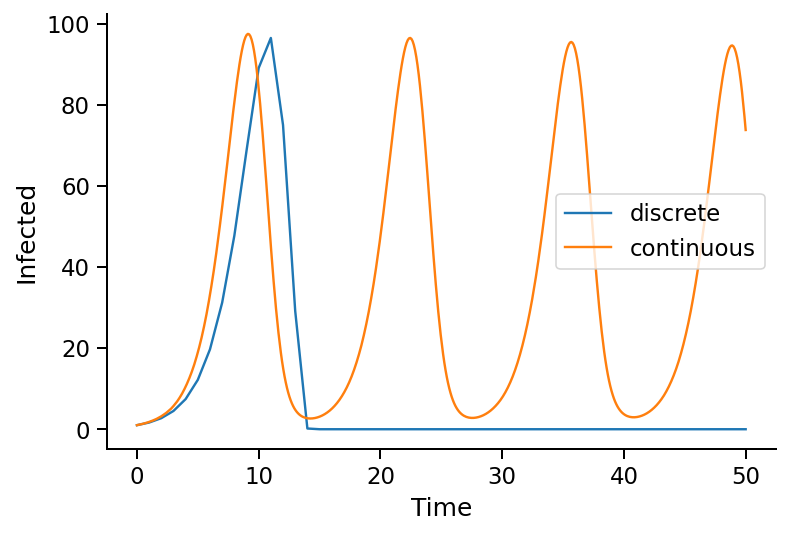

In [13]:
def I2(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat - np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

def f(St, It, IΔ, N, b0, γ, c_hat, α1, α2, min0=False, maxN=False):
    Rt = N - St - It
    α = α2 / (2 * α1) * b0
    ct = c_hat - α * IΔ / N
    bt = b0 * ct
    infected = bt * St * It
    recovered = γ * It
    St1 = St - infected
    It1 = It + infected - recovered
    St1 = np.array(St1)
    It1 = np.array(It1)
    if min0: 
        St1[St1 < 0] = 0
        It1[It1 < 0] = 0
    if maxN: 
        St1[St1 > N] = N
        It1[It1 > N] = N
    return St1, It1

def det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, min0=False, maxN=False):
    S = np.zeros(tmax+1)
    S[0] = N - I0
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t >= Δ else I0
        S[t+1], I[t+1] = f(S[t], I[t], IΔ, N, b0, γ, c_hat, α1, α2, min0, maxN)
    return I

def dde(SI, t, N, b0, γ, c_hat, α1, α2, Δ):
    S, I = SI(t)
    _, IΔ = SI(t-Δ)
    S_, I_ = f(S, I, IΔ, N, b0, γ, c_hat, α1, α2)
    return np.array([S_ - S, I_ - I])

def det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, npts=10):
    g = lambda t: np.array([N-I0, I0])
    t = np.linspace(0, tmax, tmax * npts)
    SI = ddeint(dde, g, t, fargs=(N, b0, γ, c_hat, α1, α2, Δ))    
    return t, SI[:,1]


I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, label='discrete')
t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, npts=10)
plt.plot(t, I, label='continuous')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
sns.despine()

# Fig 5 - $b_0$ vary

In [14]:
b0s = [0.005, 0.01, 0.03, 0.04, 0.05, 0.1]
results_b0s = []
for b0_ in b0s:
    Idis = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=150, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=150)
    Icont = np.maximum(Icont, 0)
    results_b0s.append((Idis, t, Icont))

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated error test failures. (Check all input.)
  self.messages.get(istate, unexpected_istate_msg)))


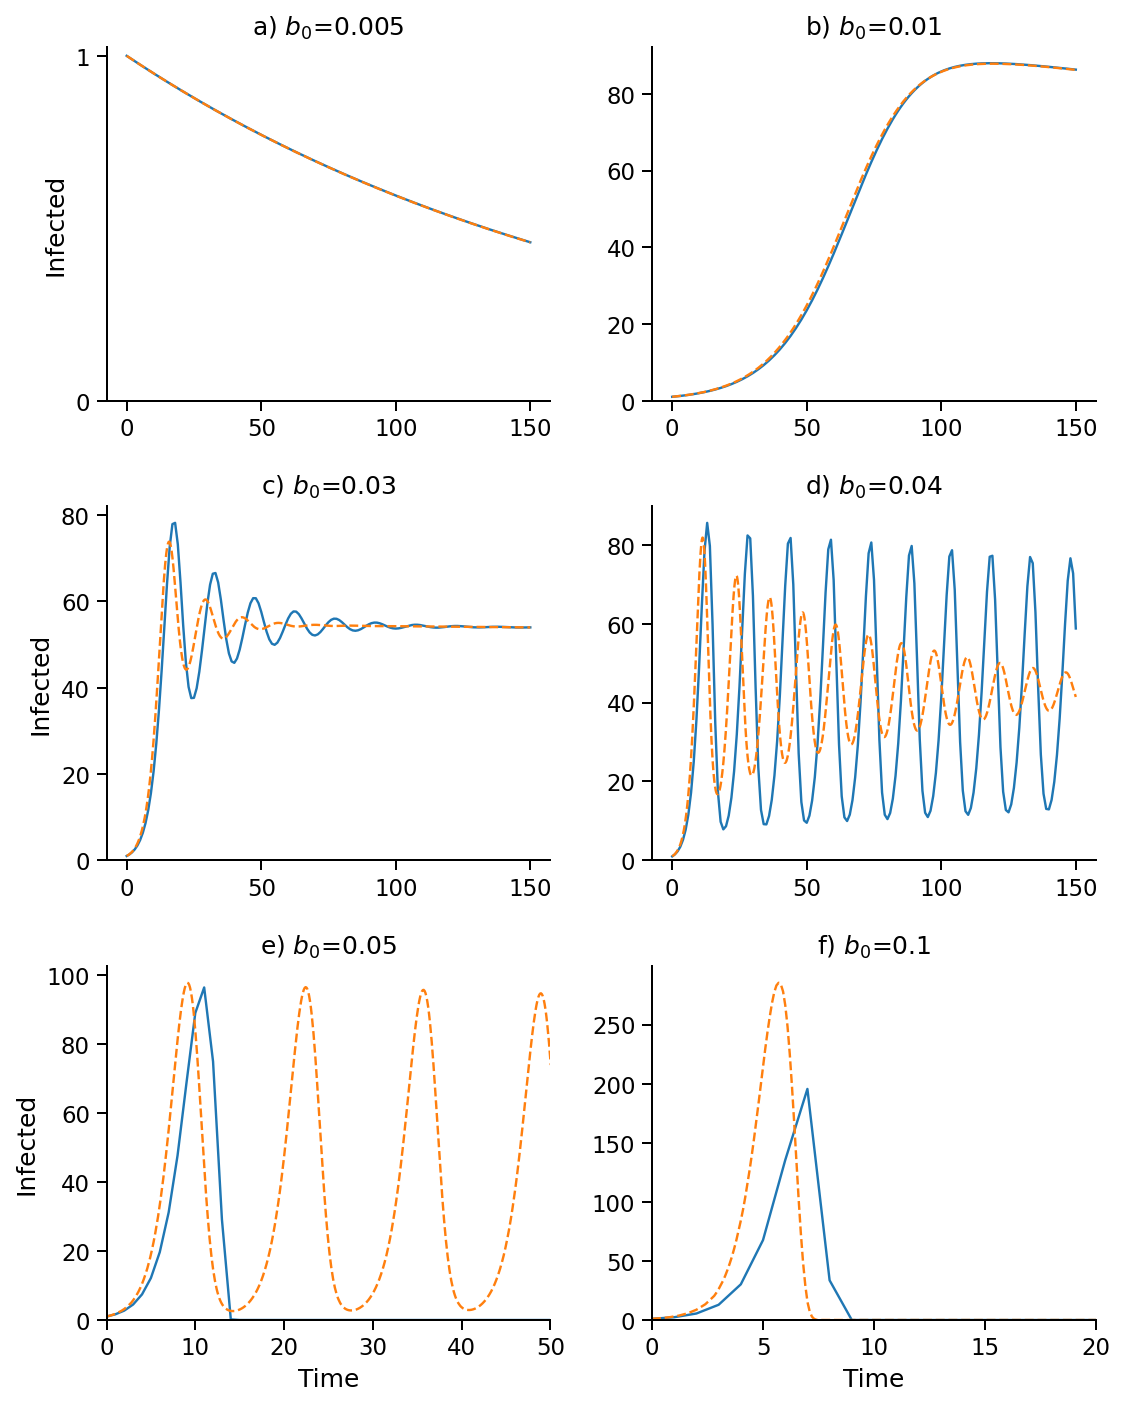

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
for b0_, ax, label, res in zip(b0s, axes.flat, 'abcdef', results_b0s):
    Idis, t, Icont = res
    ax.plot(Idis)
    ax.plot(t, Icont, '--')
    ax.set_ylim(0, None)        
    ax.set_title("{}) $b_0$={}".format(label, b0_))
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')
axes[2,0].set_xlim(0, 50)
axes[2,1].set_xlim(0, 20)
axes[0,0].set_yticks([0, 1])
# axes[-1,-1].set_ylim(0, max(Icont.max(), Idis.max()))

fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig5-SIR.pdf', dpi=100)

# Fig 3 - $\Delta$ vary

In [16]:
Δs = [0, 1, 2, 3, 4, 5]
results_Δs = []
for Δ_ in Δs:
    Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=150, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=150)
    results_Δs.append((Idis, t, Icont))

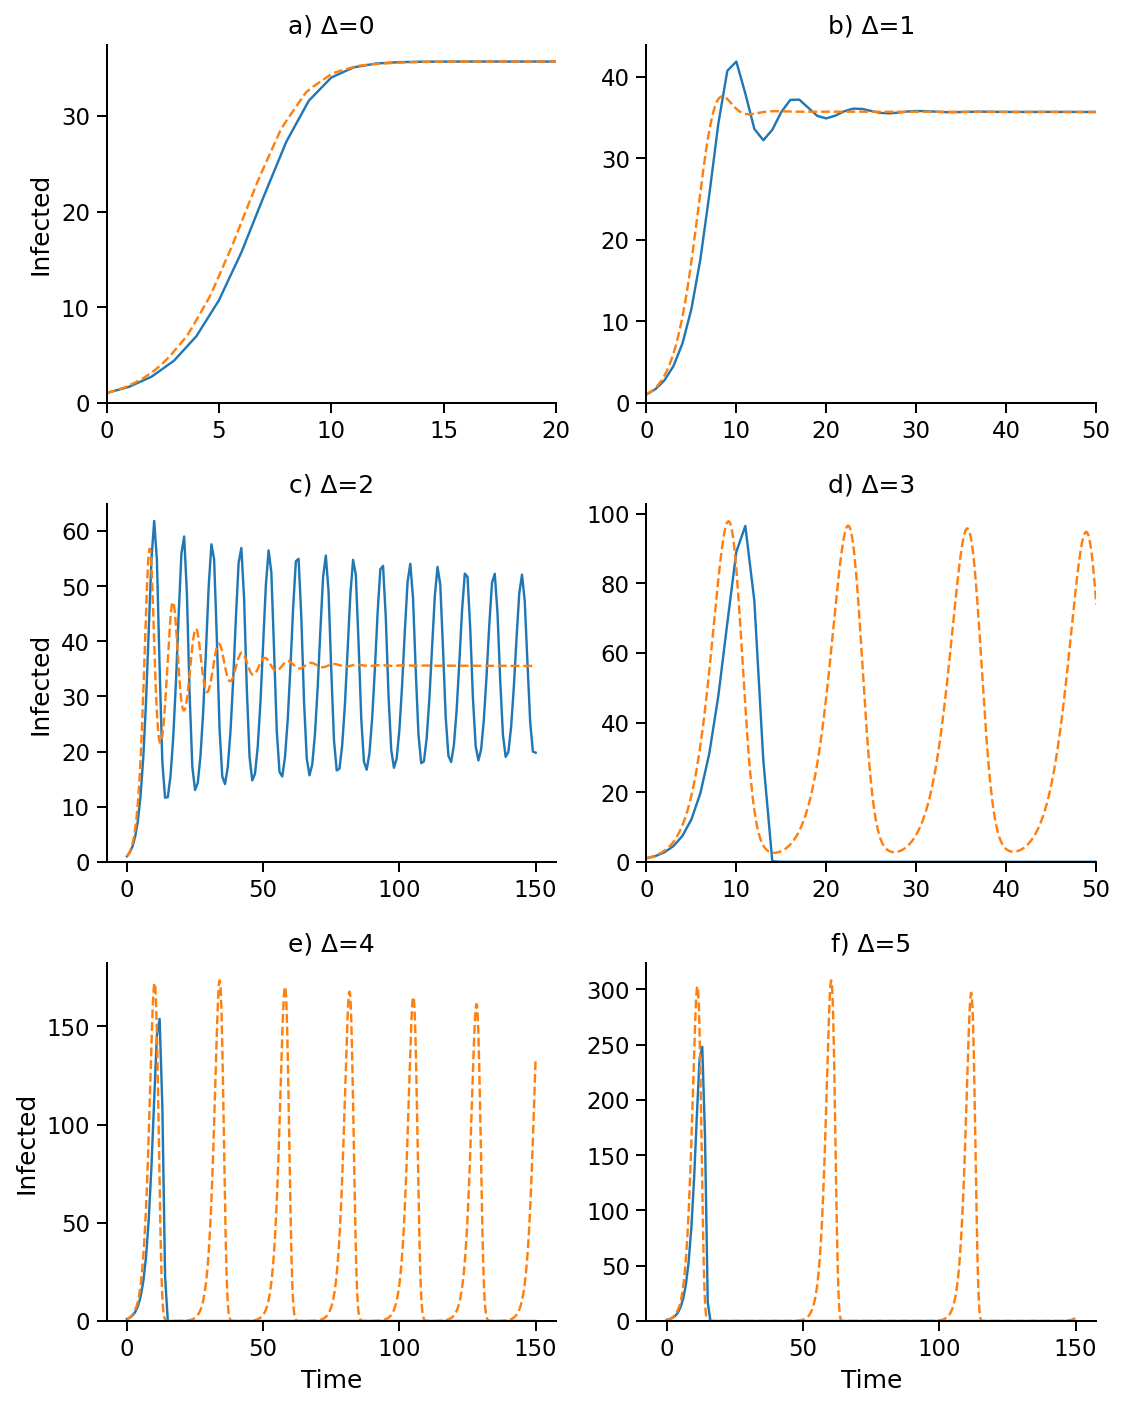

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(8, 3.33*3))
for Δ_, ax, label, res in zip(Δs, axes.flat, 'abcdef', results_Δs):
    Idis, t, Icont = res
    ax.plot(Idis)
    ax.plot(t, Icont, '--')
    ax.set_ylim(0, None)
    ax.set_title("{}) Δ={}".format(label, Δ_))
axes[0,0].set_xlim(0, 20)
axes[0,1].set_xlim(0, 50)
axes[1,1].set_xlim(0, 50)
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')

fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig3-SIR.pdf', dpi=100)

# $\hat{c}$=0.001

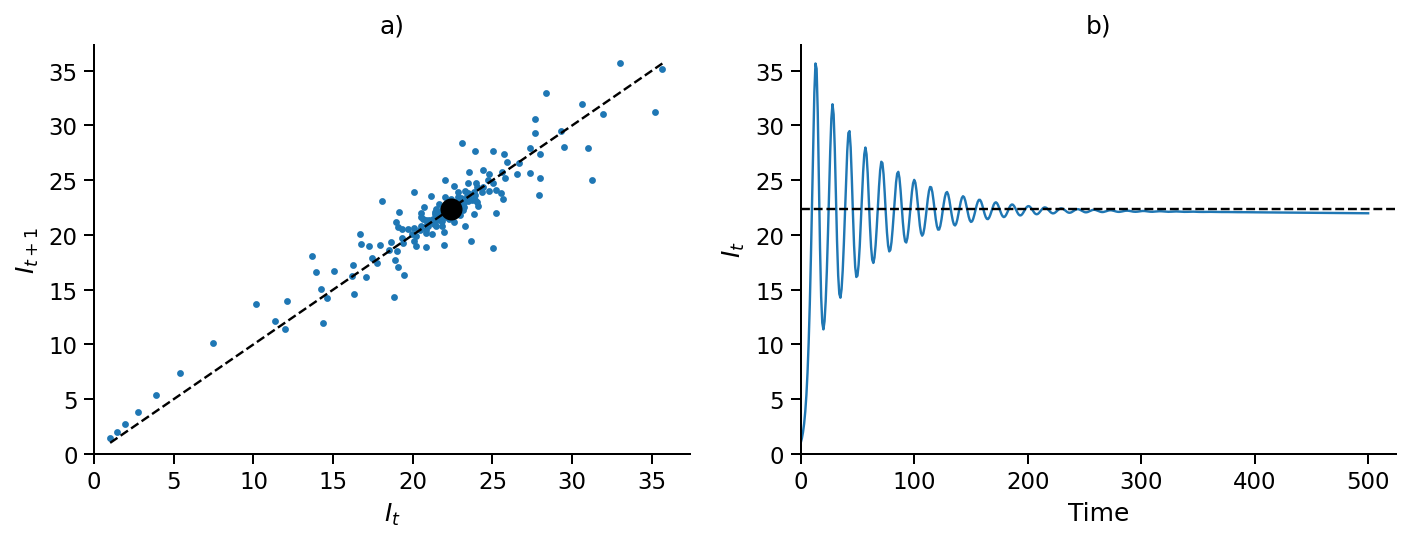

In [17]:
c_hat_ = 0.001

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
I = det_dis_simulation(I0, N, b0, γ, c_hat_, α1, α2, Δ)
ax.plot(I[:-1], I[1:], '.')
axes[1].plot(I)
line = np.linspace(I.min(), I.max())
ax.plot(line, line, ls='--', color='k')
ax.plot(I2(N, b0, γ, c_hat_, α1, α2), I2(N, b0, γ, c_hat_, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.axhline(I2(N, b0, γ, c_hat_, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

# ax.set_title('Figure X)
for ax, label in zip(axes.flat, 'abcd'): ax.set_title("{})".format(label))
sns.despine()
fig.tight_layout()
# fig.savefig('../figures/figX-SIR.pdf')

# Fig A1

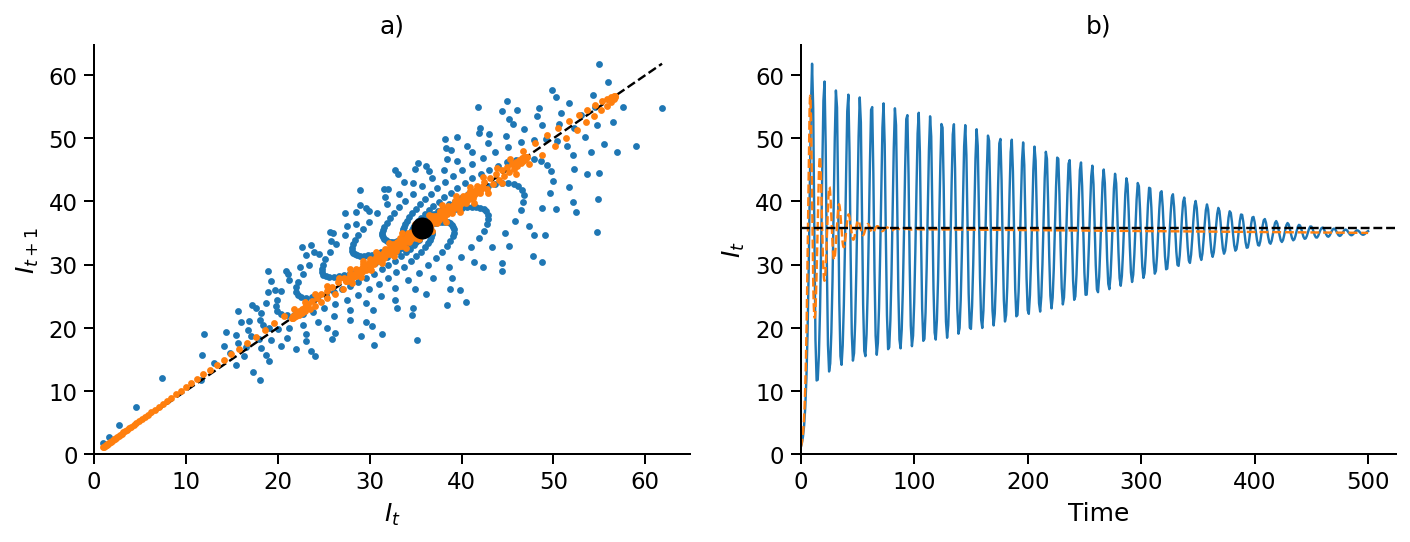

In [40]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
ax.plot(Idis[:-1], Idis[1:], '.')
line = np.linspace(Idis.min(), Idis.max())
ax.plot(line, line, ls='--', color='k')
t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
ax.plot(Icont[:-1], Icont[1:], '.')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.plot(Idis)
ax.plot(t, Icont, '--')
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

for ax, label in zip(axes.flat, 'abcd'): ax.set_title("{})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figA1-SIR.pdf')

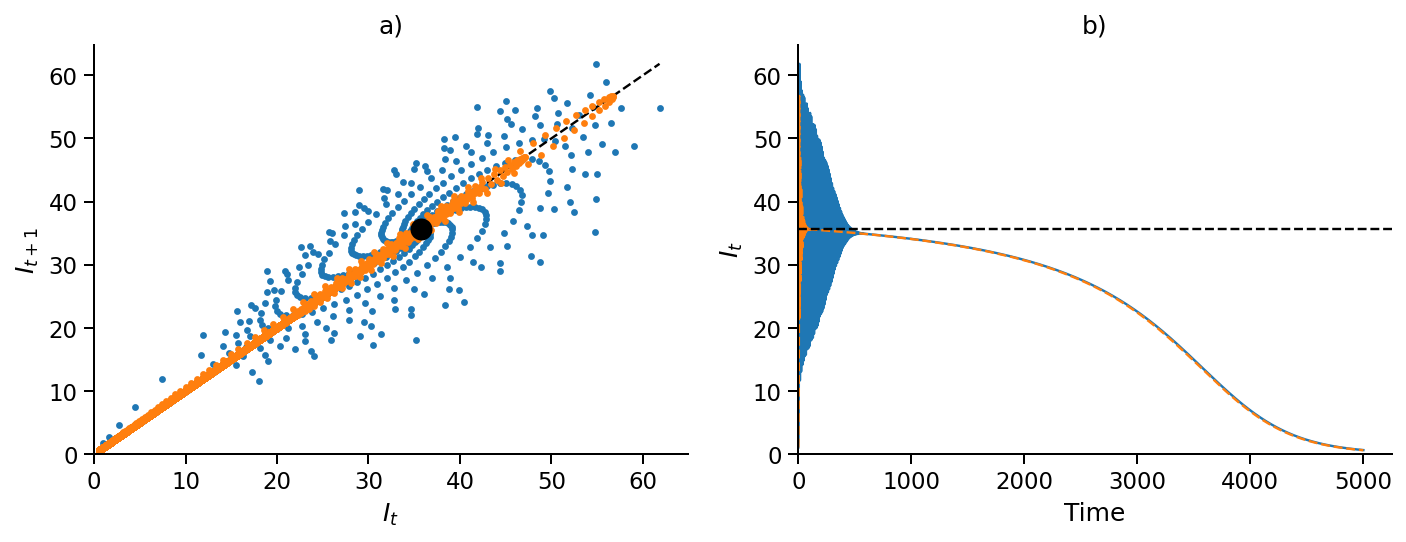

In [41]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=5000)
ax.plot(Idis[:-1], Idis[1:], '.')
line = np.linspace(Idis.min(), Idis.max())
ax.plot(line, line, ls='--', color='k')
t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=5000)
ax.plot(Icont[:-1], Icont[1:], '.')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.plot(Idis)
ax.plot(t, Icont, '--')
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

for ax, label in zip(axes.flat, 'abcd'): ax.set_title("{})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figA1-SIR-long.pdf')

# Table 1: Δ=3, b0 varies

In [56]:
N=10000
I0=1
b0s=[0.005, 0.01, 0.03, 0.04, 0.05]
γ=0.08
c_hat=0.0015
α1=0.02
α2=0.3 
Δ=3

classifications = ['Mon. convergence to I0', 'Mon. convergence to I2', 'Damped oscillation to I2', 'Perpetual oscillation', 'Collapse']

In [57]:
results_table1 = []
for b0_ in b0s:
    S, I = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=250, min0=True, maxN=True)
    results_table1.append(I)

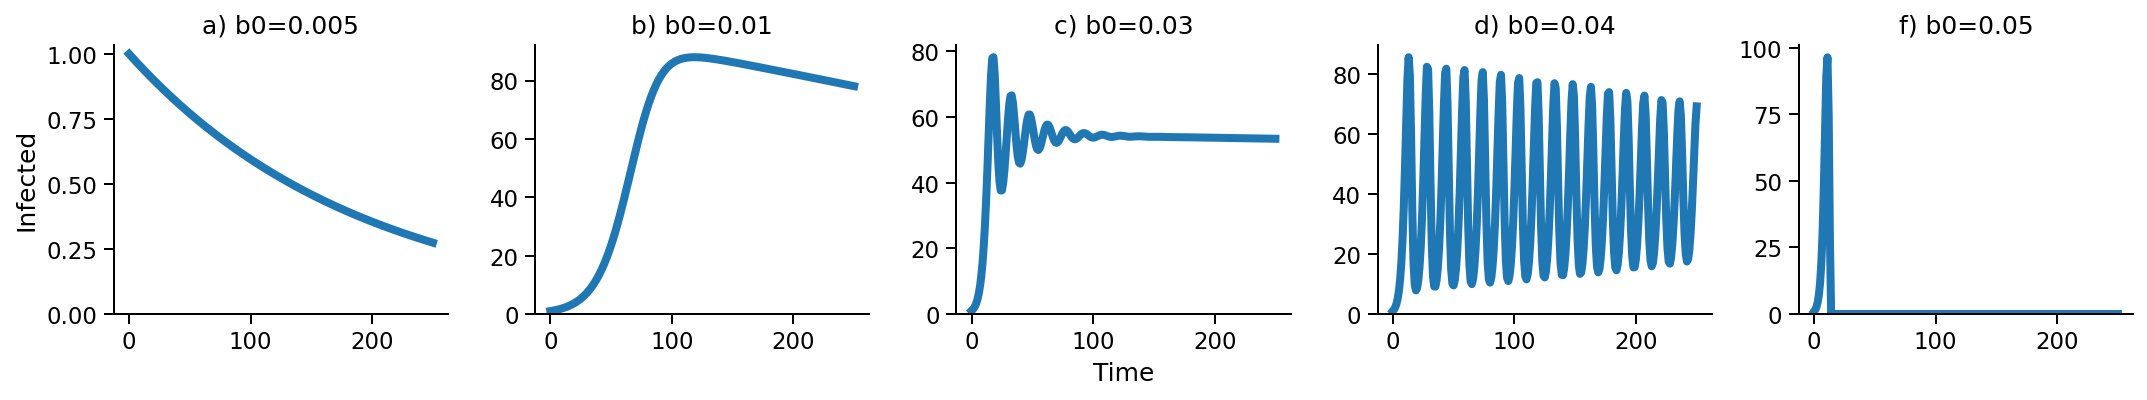

In [58]:
fig, axes = plt.subplots(1, len(b0s), figsize=(15, 3), sharex=True)
for label, ax, b0_, res, classif in zip('abcdfef', axes.flat, b0s, results_table1, classifications):
#     I1_ = I1(N, b0_, γ, c_hat, α1, α2)
#     I2_ = I2(N, b0_, γ, c_hat, α1, α2)
#     print('b0={:12}\tI1={:12.2f}\tI2={:12.2f}'.format(b0_, I1_, I2_))
    I = res
    ax.plot(I, lw=4)
#     ax.plot(t, Icont, '-', lw=2)    
#     ax.axhline(I2_, color='k')
    ax.set(ylim=(0, None), title='{}) b0={}'.format(label, b0_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.tight_layout()
sns.despine()
# fig.savefig('../figures/figX.pdf', dpi=100)

# Fig 6, Table 2: Δ = 3, γ varies

In [20]:
N=10000
I0=1
b0=0.05
γs=[0.1,0.2,0.45,0.65,0.75]
c_hat=0.0015
α1=0.02
α2=0.3 
Δ=3

classifications = ['Collapse', 'Perpetual oscillation', 'Damped oscillation to I2', 'Mon. convergence to I2', 'Mon. convergence to I0']

In [21]:
results_table2 = []
for γ_ in γs:
    Idis = det_dis_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=250)
    results_table2.append((Idis, t, Icont))

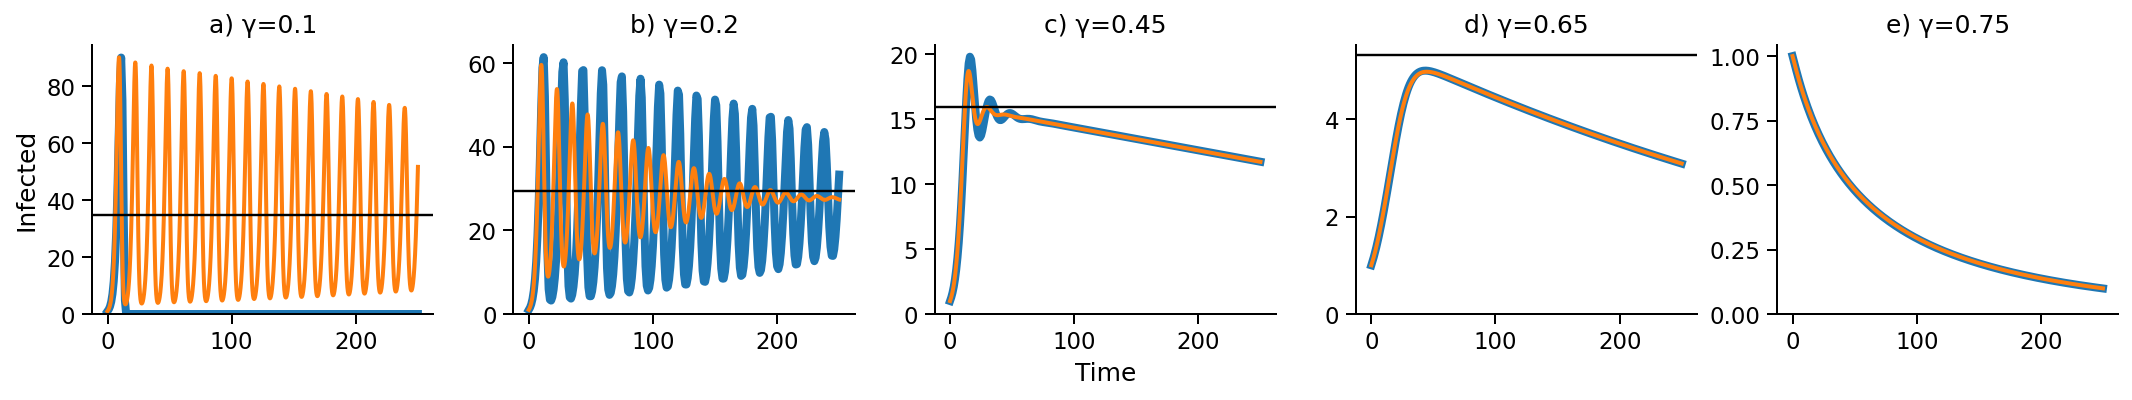

In [23]:
fig, axes = plt.subplots(1, len(γs), figsize=(15, 3), sharex=True)
for label, ax, γ_, res, classif in zip('abcdef', axes.flat, γs, results_table2, classifications):
    Idis, t, Icont = res
    ax.plot(Idis, lw=4)
    ax.plot(t, Icont, '-', lw=2)
    ax.axhline(I2(N, b0, γ_, c_hat, α1, α2), color='k')
    ax.set(ylim=(0, None), title='{}) γ={}'.format(label, γ_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')

fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig6-SIR.pdf', dpi=100)

In [24]:
results_table2_long = []
for γ_ in γs:
    Idis = det_dis_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=5000, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=5000)
    results_table2_long.append((Idis, t, Icont))

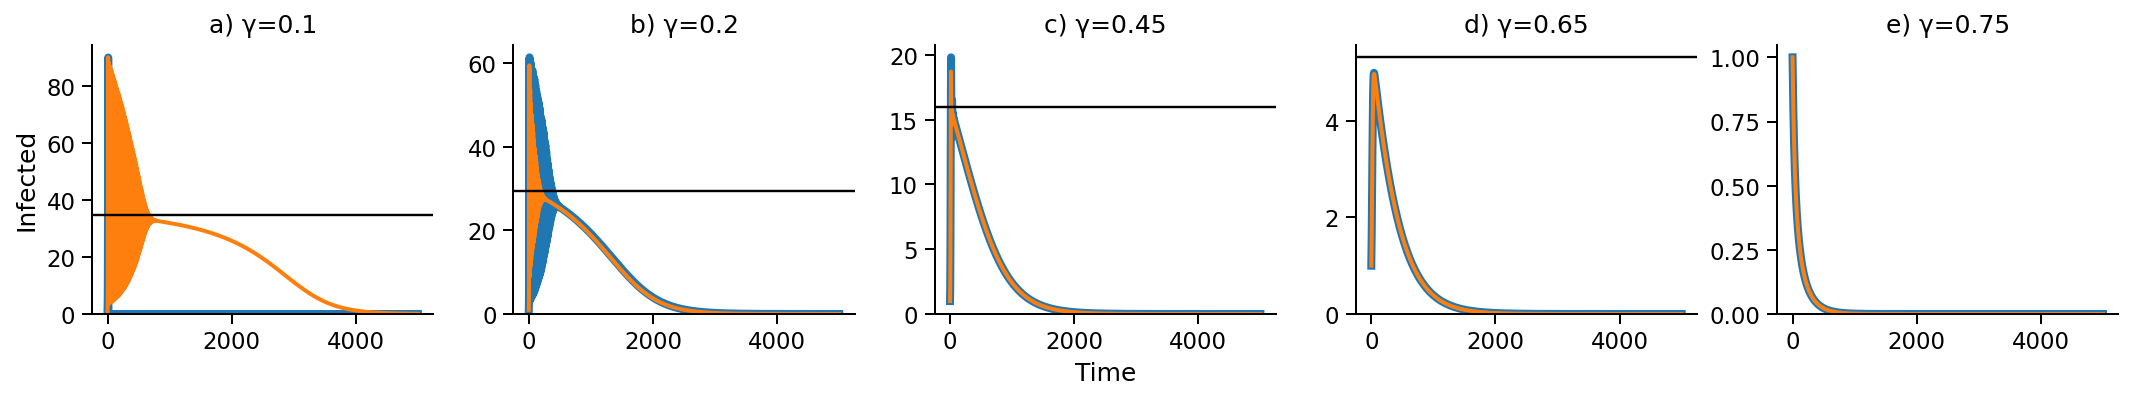

In [25]:
fig, axes = plt.subplots(1, len(γs), figsize=(15, 3), sharex=True)
for label, ax, γ_, res, classif in zip('abcdef', axes.flat, γs, results_table2_long, classifications):
    Idis, t, Icont = res
    ax.plot(Idis, lw=4)
    ax.plot(t, Icont, '-', lw=2)
    ax.axhline(I2(N, b0, γ_, c_hat, α1, α2), color='k')
    ax.set(ylim=(0, None), title='{}) γ={}'.format(label, γ_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')

fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig6-SIR-long.pdf', dpi=100)

# Table 3: Δ shift

In [94]:
N=10000
I0=1
b0=0.05
γ=0.08
c_hat=0.0015
α1=0.02
α2=0.3 
Δs=0,1,2,3,4

classifications = ['Mon. convergence to I2', 'Damped oscillation to I2', 'Perpetual oscillation', 'Collapse', 'Collapse']

In [22]:
results_table3 = []
for Δ_ in Δs:
    Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=250)
    results_table3.append((Idis, t, Icont))

In [ ]:
fig, axes = plt.subplots(1, len(Δs), figsize=(15, 3), sharex=True)
for label, ax, Δ_, res, classif in zip('abcdef', axes.flat, Δs, results_table3, classifications):
    Idis, t, Icont = res
    ax.plot(Idis, lw=4)
    ax.plot(t, Icont, lw=2)    
    ax.axhline(I2_, color='k')
    ax.set(ylim=(0, None), title='{}) Δ={}'.format(label, Δ_))
#     ax.set(xlabel='Time', ylim=(0, None), title='Δ={}\n{}\n(<1? {})'.format(Δ_, classif, (Icont<1).any()))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.tight_layout()
sns.despine()
# fig.savefig('../figures/fig.pdf', dpi=100)

# Fig 4 - $I_0$ varies

In [27]:
# I1_ = I1(N, b0, γ, c_hat, α1, α2)
I2_ = I2(N, b0, γ, c_hat, α1, α2)

# print('I1={:.2f}\tdfdI(I1)={:.2f}'.format(I1_, dfdI(I1_, N, b0, γ, c_hat, α1, α2)))
print('I2={:.2f}'.format(I2_))#, dfdI(I2_, N, b0, γ, c_hat, α1, α2)))

I2=35.72


In [26]:
I0s = [1, 35, 50, 90]
results_I0s = []
for I0_ in I0s:
    Idis = det_dis_simulation(I0_, N, b0, γ, c_hat, α1, α2, Δ=2, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0_, N, b0, γ, c_hat, α1, α2, Δ=2, tmax=250)
    results_I0s.append([Idis, t, Icont])

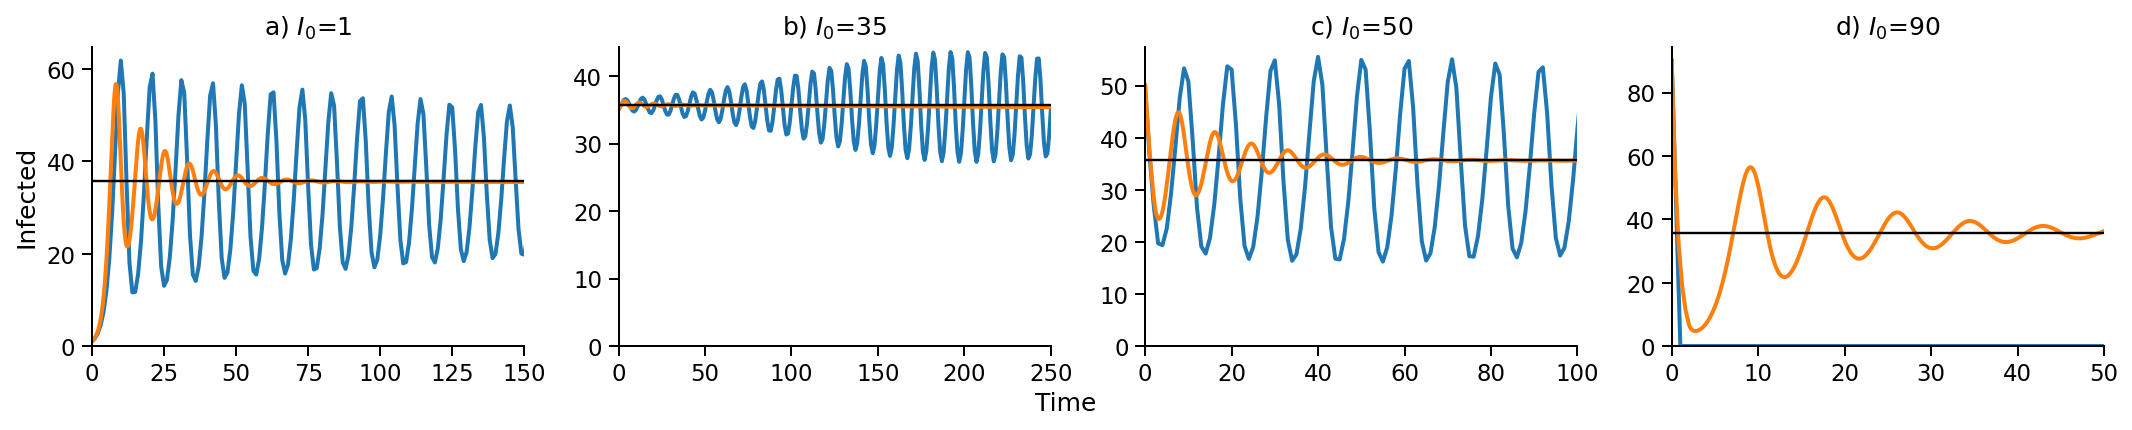

In [29]:
fig, axes = plt.subplots(1, len(I0s), figsize=(15, 3))
for label, ax, I0_, res in zip('abcdef', axes.flat, I0s, results_I0s):
    Idis, t, Icont = res
    ax.plot(Idis, lw=2)
    ax.plot(t, Icont, lw=2) 
    ax.axhline(I2_, color='k')
    ax.set(title='{}) $I_0$={}'.format(label, I0_), ylim=(0, None), xlim=(0, None))
axes[0].set_ylabel('Infected')
fig_xlabel(fig, 'Time')

axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 250)
axes[2].set_xlim(0, 100)
axes[3].set_xlim(0, 50)

# fig.suptitle('Figure 4')
fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig4-SIR.pdf')